<a href="https://colab.research.google.com/github/vinhngx/DeepLearningExamples/blob/vinhn_unet_industrial_demo/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorFlow_UNet_Industrial_TF_train_and_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# UNet Industrial Training and Inference Demo

## Overview


This U-Net model is adapted from the original version of the [U-Net model](https://arxiv.org/abs/1505.04597) which is
a convolutional auto-encoder for 2D image segmentation. U-Net was first introduced by
Olaf Ronneberger, Philip Fischer, and Thomas Brox in the paper:
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597).

This work proposes a modified version of U-Net, called `TinyUNet` which performs efficiently and with very high accuracy
on the industrial anomaly dataset [DAGM2007](https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html).
*TinyUNet*, like the original *U-Net* is composed of two parts:
- an encoding sub-network (left-side)
- a decoding sub-network (right-side).

It repeatedly applies 3 downsampling blocks composed of two 2D convolutions followed by a 2D max pooling
layer in the encoding sub-network. In the decoding sub-network, 3 upsampling blocks are composed of a upsample2D
layer followed by a 2D convolution, a concatenation operation with the residual connection and two 2D convolutions.

`TinyUNet` has been introduced to reduce the model capacity which was leading to a high degree of over-fitting on a
small dataset like DAGM2007. The complete architecture is presented in the figure below:

![UnetModel](https://github.com/vinhngx/DeepLearningExamples/blob/vinhn_unet_industrial_demo/TensorFlow/Segmentation/UNet_Industrial/images/unet.png?raw=1)



### Learning objectives

This notebook demonstrates the steps for training a UNet model. We then employ the trained model to make inference on new images.

## Content
1. [Requirements](#1)
1. [Data download and preprocessing](#2)
1. [Training](#3)
1. [Testing trained model](#4)


<a id="1"></a>
## 1. Requirements


### 1.1 Docker container
The most convenient way to make use of the NVIDIA Tensorflow UNet model is via a docker container, which provides a self-contained, isolated and re-producible environment for all experiments. Refer to the [Quick Start Guide section](https://github.com/vinhngx/DeepLearningExamples/tree/vinhn_unet_industrial_demo/TensorFlow/Segmentation/UNet_Industrial#requirements) of the Readme documentation for a comprehensive guide. We briefly summarize the steps here.

First, clone the repository:

```
git clone https://github.com/NVIDIA/DeepLearningExamples.git
cd DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial
```

Next, build the NVIDIA UNet_Industrial container:

```
docker build . --rm -t unet_industrial:latest
```

Then launch the container with:

```
nvidia-docker run -it --rm \
    --shm-size=2g --ulimit memlock=-1 --ulimit stack=67108864 \
    -v /path/to/dataset:/data/dagm2007/ \
    -v /path/to/results:/results \
    unet_industrial:latest
```
where `/path/to/dataset` is the path on the host machine where the data was/is to be downloaded. More on data set preparation in the next section. `/path/to/results` is wher the trained model will be stored.

Within the docker interactive bash session, start Jupyter with

```
jupyter notebook --ip 0.0.0.0 --port 8888
```

Then open the Jupyter GUI interface on your host machine at http://localhost:8888. Within the container, this notebook itself is located at `/workspace/unet_industrial/notebooks`.

### 1.2 Hardware
This notebook can be executed on any CUDA-enabled NVIDIA GPU, although for efficient mixed precision training, a [Tensor Core NVIDIA GPU](https://www.nvidia.com/en-us/data-center/tensorcore/) is desired (Volta, Turing or newer architectures). 

In [2]:
!nvidia-smi

Mon Sep 30 04:12:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   41C    P0    60W / 300W |    316MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

<a id="2"></a>
## 2. Data download and preprocessing

We will first download some data, in particular, the [Weakly Supervised Learning for Industrial Optical Inspection (DAGM 2007)](https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html) dataset. 

> The competition is inspired by problems from industrial image processing. In order to satisfy their customers' needs, companies have to guarantee the quality of their products, which can often be achieved only by inspection of the finished product. Automatic visual defect detection has the potential to reduce the cost of quality assurance significantly.
>
> The competitors have to design a stand-alone algorithm which is able to detect miscellaneous defects on various background textures.
>
> The particular challenge of this contest is that the algorithm must learn, without human intervention, to discern defects automatically from a weakly labeled (i.e., labels are not exact to the pixel level) training set, the exact characteristics of which are unknown at development time. During the competition, the programs have to be trained on new data without any human guidance.

**Source:** https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html


**Important Information**: The data download script below will download the *public* DAGM 2007 data set, while the *private* DAGM 2007 requires an account to be downloaded. The script will invite you to download them manually and put them in the correct directory for subsequent pre-processing. We will employ the *private* DAGM data set of 10 classes to train UNnet models.

In [4]:
! ../download_and_preprocess_dagm2007.sh ./data


################################################
Processing Public Dataset
################################################

Archive:  /data/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class1.zip
Archive:  /data/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class1_def.zip
Archive:  /data/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class2.zip
Archive:  /data/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class2_def.zip
Archive:  /data/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class3.zip
Archive:  /data/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class3_def.zip
Archive:  /data/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class4.zip
Archive:  /data/DeepLe

Within the docker container, the final data directory should look like:

```
./data
  raw_images
      public
          Class1	    
          Class2	
          Class3	    
          Class4	
          Class5	    
          Class6
          Class1_def  
          Class2_def	
          Class3_def  
          Class4_def	
          Class5_def  
          Class6_def
      private
          Class1  
          Class10  
          Class2  
          Class3  
          Class4  
          Class5  
          Class6  
          Class7  
          Class8  
          Class9
  zip_files
```

<a id="3"></a>
## 3. Training

The repository provides several training recipes with 1, 4 and 8 GPU with FP32 and automatic mixed precision in `./script`.

### 3.1 Training with 1 GPU


#### Training with full precision
Training on 1 GPU with FP32 with the following syntax:

```
./UNet_FP32_1GPU.sh <path to result repository> <path to dataset> <DAGM2007 classID (1-10)
```

For example: 
```
../scripts/UNet_FP32_1GPU.sh ./results/1GPU-FP32 /CDR/DAGM10 1
```
                        
Note that inside the shell script it make use of the main python trains script.

In [ ]:
RESULT_DIR="./results/1GPU-FP32"
DATA_DIR="/CDR/DAGM10"
CLASS="1"
%run ../main.py \
    --unet_variant='tinyUNet' \
    --activation_fn='relu' \
    --exec_mode='train_and_evaluate' \
    --iter_unit='batch' \
    --num_iter=2500 \
    --batch_size=16 \
    --warmup_step=10 \
    --results_dir={RESULT_DIR} \
    --data_dir={DATA_DIR} \
    --dataset_name='DAGM2007' \
    --dataset_classID={CLASS} \
    --data_format='NCHW' \
    --use_auto_loss_scaling \
    --nouse_tf_amp \
    --nouse_xla \
    --learning_rate=1e-4 \
    --learning_rate_decay_factor=0.8 \
    --learning_rate_decay_steps=500 \
    --rmsprop_decay=0.9 \
    --rmsprop_momentum=0.8 \
    --loss_fn_name='adaptive_loss' \
    --weight_decay=1e-5 \
    --weight_init_method='he_uniform' \
    --augment_data \
    --display_every=250 \
    --debug_verbosity=0

#### Training with mixed-precision
We now launch the training process using mixed precision. Training on 1 GPU with automatic mixed precision (AMP) with the following syntax:

```
./UNet_AMP_1GPU.sh <path to result repository> <path to dataset> <DAGM2007 classID (1-10)
```

For example: 
```
../scripts/UNet_AMP_1GPU.sh ./results/1GPU-AMP/CDR/DAGM10 1
```
                        
Note that inside the shell script it make use of the main python trains script.

In [ ]:
RESULT_DIR="./results/1GPU-FP16"
DATA_DIR="/CDR/DAGM10"
CLASS="1"
%run ../main.py \
    --unet_variant='tinyUNet' \
    --activation_fn='relu' \
    --exec_mode='train_and_evaluate' \
    --iter_unit='batch' \
    --num_iter=2500 \
    --batch_size=16 \
    --warmup_step=10 \
    --results_dir={RESULT_DIR} \
    --data_dir={DATA_DIR} \
    --dataset_name='DAGM2007' \
    --dataset_classID={CLASS} \
    --data_format='NCHW' \
    --use_auto_loss_scaling \
    --use_tf_amp \
    --nouse_xla \
    --learning_rate=1e-4 \
    --learning_rate_decay_factor=0.8 \
    --learning_rate_decay_steps=500 \
    --rmsprop_decay=0.9 \
    --rmsprop_momentum=0.8 \
    --loss_fn_name='adaptive_loss' \
    --weight_decay=1e-5 \
    --weight_init_method='he_uniform' \
    --augment_data \
    --display_every=250 \
    --debug_verbosity=0

### 3.2. Training with 8 GPUs

We provide training recipes for 8 GPUs using FP32 or automatic mixed precision (AMP)

#### Training with full precision


In [ ]:
!../scripts/UNet_FP32_8GPU.sh ./results/8GPU-FP32 /CDR/DAGM10 1

#### Training with automatic mixed precision (AMP)

In [ ]:
!../scripts/UNet_AMP_8GPU.sh ./results/8GPU-AMP /CDR/DAGM10 1

<a id="4"></a>
## 4. Testing trained model

After model training has completed, we can test the trained model against the DAGM 2007 public data set which wasn't used for training. First, we load some required libraries and define some helper functions to load images.

In [11]:
import sys
sys.path.insert(0,'..')

from model.unet import UNet_v1

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


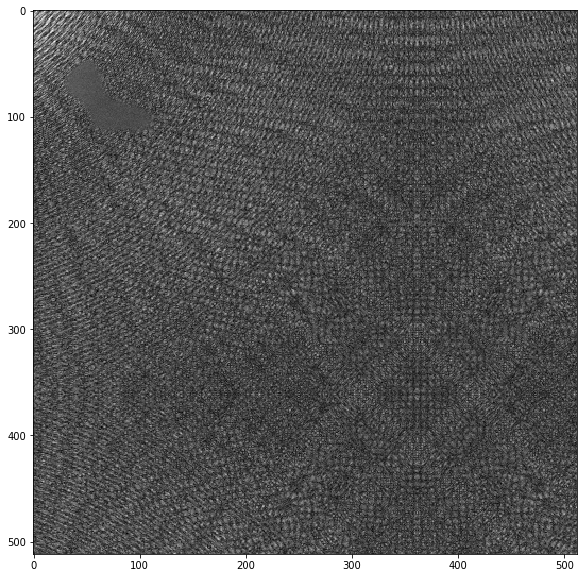

In [12]:
img = mpimg.imread('./data/raw_images/public/Class1_def/1.png')

plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')

As we can see in this figure, there exists a defective area in the top left corner. We will now load the model and carry out inference on the normalized test image.

In [13]:
# Image preprocessing
img =  np.expand_dims(img, axis=2)
img =  np.expand_dims(img, axis=0)
img = (img-0.5)/0.5

Next, we start a TF session, load the trained UNet model and carry out inference on the test image.

In [16]:
!ls ./results/1GPU-FP16/checkpoints  

checkpoint
eval
events.out.tfevents.1569830054.ac4fd7ffba26
graph.pbtxt
model.ckpt-0.data-00000-of-00002
model.ckpt-0.data-00001-of-00002
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00002
model.ckpt-1000.data-00001-of-00002
model.ckpt-1000.index
model.ckpt-1000.meta
model.ckpt-2000.data-00000-of-00002
model.ckpt-2000.data-00001-of-00002
model.ckpt-2000.index
model.ckpt-2000.meta
model.ckpt-2500.data-00000-of-00002
model.ckpt-2500.data-00001-of-00002
model.ckpt-2500.index
model.ckpt-2500.meta


In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
        
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
        outputs, logits = network.build_model(tf_input)
        saver = tf.train.Saver()

        # Restore variables from disk.
        saver.restore(sess, "./results/1GPU-FP16/checkpoints/model.ckpt-2500")
        
        
        output = sess.run([outputs, logits], feed_dict={tf_input: img})
        


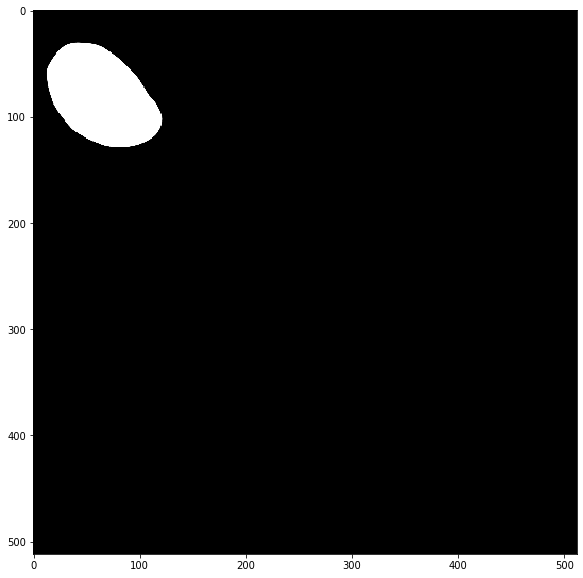

In [18]:
# Print out model predicted mask
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

As expected, the model points out the correct defective area in this image. Please feel free to try out other defective images within `./data/raw_images/public/Class1_def/`

In [20]:
!ls ./data/raw_images/public/Class1_def/

1.png	 114.png  13.png   145.png  25.png  40.png  56.png  71.png  87.png
10.png	 115.png  130.png  146.png  26.png  41.png  57.png  72.png  88.png
100.png  116.png  131.png  147.png  27.png  42.png  58.png  73.png  89.png
101.png  117.png  132.png  148.png  28.png  43.png  59.png  74.png  9.png
102.png  118.png  133.png  149.png  29.png  44.png  6.png   75.png  90.png
103.png  119.png  134.png  15.png   3.png   45.png  60.png  76.png  91.png
104.png  12.png   135.png  150.png  30.png  46.png  61.png  77.png  92.png
105.png  120.png  136.png  16.png   31.png  47.png  62.png  78.png  93.png
106.png  121.png  137.png  17.png   32.png  48.png  63.png  79.png  94.png
107.png  122.png  138.png  18.png   33.png  49.png  64.png  8.png   95.png
108.png  123.png  139.png  19.png   34.png  5.png   65.png  80.png  96.png
109.png  124.png  14.png   2.png    35.png  50.png  66.png  81.png  97.png
11.png	 125.png  140.png  20.png   36.png  51.png  67.png  82.png  98.png
110.png  126.png  141.png  21.

# Conclusion

In this notebook, we have walked through the complete process of preparing the container and data required for training the UNet-Industrial models. We have also investigated various training options with FP32 and automatic mixed precision, trained and tested UNet models with new test images.

## What's next
Now it's time to try the UNet model on your own data. Observe the performance impact of mixed precision training while comparing the final accuracy of the models trained with FP32 and mixed precision.
